## First chapter

In [ ]:
%pip install pandas
%pip install seaborn
%pip install matplotlib
%pip install pycountry-convert
%pip install scipy
%pip install geopy
%pip install geocoder
%pip install scikit-learn

ERROR: Operation cancelled by user
^C
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.0/244.0 kB 14.8 MB/s eta 0:00:00


In [ ]:
from geopy import geocoders, Nominatim
import geocoder
import scipy.stats as ss
import pycountry_convert as pc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
# df1 = pd.read_csv("cost-of-living_v2.csv")
df1 = pd.read_csv("cost-of-living.csv", index_col=0)

attribute_names = {
    "x1": "meal_inexpensive",
    "x2": "meal_mid_range",
    "x3": "mcmeal",
    "x4": "domestic_beer_restaurant",
    "x5": "imported_beer_restaurant",
    "x6": "cappuccino",
    "x7": "coke",
    "x8": "water",
    "x9": "milk",
    "x10": "white_bread",
    "x11": "rice",
    "x12": "eggs",
    "x13": "cheese",
    "x14": "chicken",
    "x15": "beef",
    "x16": "apples",
    "x17": "banana",
    "x18": "oranges",
    "x19": "tomato",
    "x20": "potato",
    "x21": "onion",
    "x22": "lettuce",
    "x23": "water",
    "x24": "wine",
    "x25": "domestic_beer_market",
    "x26": "imported_beer_market",
    "x27": "cigarettes",
    "x28": "one_way_ticket",
    "x29": "monthly_pass",
    "x30": "taxi_start",
    "x31": "taxi_1km",
    "x32": "taxi_1h",
    "x33": "gasoline",
    "x34": "vw_golf",
    "x35": "toyota_corolla",
    "x36": "basic_85m2",
    "x37": "1min_prepaid",
    "x38": "internet",
    "x39": "fitness_club",
    "x40": "tennis",
    "x41": "cinema",
    "x42": "preschool",
    "x43": "primary_school",
    "x44": "jeans",
    "x45": "summer_dress",
    "x46": "nike_shoes",
    "x47": "business_shoes",
    "x48": "apartment_1br_center",
    "x49": "apartment_1br_outside",
    "x50": "apartment_3br_center",
    "x51": "apartment_3br_outside",
    "x52": "per_square_meter_center",
    "x53": "per_square_meter_outside",
    "x54": "avg_month_salary",
    "x55": "mortgage_interest",
}
attr_keys = list(attribute_names.keys())
len(df1)

4874

## Data Preperation

In [ ]:
# Filter for high-quality datasets
df1 = df1[df1["data_quality"]==1].reset_index(drop=True)

# Add name of continent
def country_name_to_continent_name(country_name):
    exceptions = {
        "Bosnia And Herzegovina": "Europe",
        "Trinidad And Tobago": "South America",
        "Isle Of Man": "Europe",
        "Curacao": "South America",
        "Kosovo (Disputed Territory)": "Europe",
    }
    if country_name in exceptions.keys():
        return exceptions[country_name]
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None

df1["continent"] = df1["country"].apply(country_name_to_continent_name)



# Get geo-coordinates of city
def city_to_lat_lon(city_name, parameter):
  loc = Nominatim(user_agent="user_42")
  getLoc = loc.geocode(city_name)
  return getLoc.longitude if parameter=="longitude" else getLoc.latitude

#df1["latitude"] = df1["city"].apply(lambda x: city_to_lat_lon(x, "latitude"))
#df1["longitude"] = df1["city"].apply(lambda x: city_to_lat_lon(x, "longitude"))

# Get elevation of city
# maybe use this as self-hosted solution instead? https://www.opentopodata.org/
def get_elevation(row):
    query = 'https://api.open-meteo.com/v1/elevation?' + \
            f'latitude={row["latitude"]}&longitude={row["longitude"]}'
    print(query)
    r = requests.get(query).json()
    elevation = pd.io.json.json_normalize(r, 'results')['elevation'].values[0]
    return elevation
#df1["elevation"] = df1.apply(get_elevation)

df1

,city,country,x1,x2,x3,x4,x5,x6,x7,x8,...,x48,x49,x50,x51,x52,x53,x54,x55,data_quality,continent
0,Delhi,India,4.90,22.04,4.28,1.84,3.67,1.78,0.48,0.19,...,223.87,133.38,596.16,325.82,2619.46,1068.90,586.35,7.96,1,Asia
1,Shanghai,China,5.59,40.51,5.59,1.12,4.19,3.96,0.52,0.32,...,1080.07,564.30,2972.57,1532.23,17333.09,9174.88,1382.83,5.01,1,Asia
2,Jakarta,Indonesia,2.54,22.25,3.50,2.02,3.18,2.19,0.59,0.27,...,482.85,270.15,1117.69,584.37,2694.05,1269.44,483.19,9.15,1,Asia
3,Manila,Philippines,3.54,27.40,3.54,1.24,1.90,2.91,0.93,0.51,...,559.52,281.78,1754.40,684.81,3536.04,2596.44,419.02,7.80,1,Asia
4,Seoul,South Korea,7.16,52.77,6.03,3.02,4.52,3.86,1.46,0.78,...,809.83,583.60,2621.05,1683.74,21847.94,10832.90,2672.23,3.47,1,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,Haugesund,Norway,15.37,80.43,12.06,8.60,8.55,4.32,3.34,2.87,...,703.75,552.95,1306.93,1080.73,2473.18,2243.39,3310.20,2.57,1,Europe
906,Lagos,Portugal,8.31,62.32,7.27,2.60,2.60,1.77,1.77,1.42,...,869.91,706.31,1627.29,1201.74,3467.10,3401.40,910.11,3.33,1,Europe
907,Porto Calvo,Brazil,4.66,25.16,5.59,1.86,2.24,1.69,1.03,0.69,...,298.14,241.46,542.24,444.88,1229.83,1071.44,385.78,8.17,1,South America
908,Fairfax,United States,19.38,75.00,10.00,6.00,7.62,5.06,2.42,1.78,...,2200.00,1733.33,3560.00,2825.00,6754.35,2891.90,6117.78,4.90,1,North America


## Feature Engineering

In [ ]:

# Determine number of start
print("Number of datasets: " + str(df1.shape[0]))
print("Number of features: " + str(df1.shape[1]))

# Replacing None values with median value of column
df1[attr_keys] = df1[attr_keys].fillna(df1[attr_keys].median())

# Removing outliers
#for col in attr_keys:
#  df1 = df1[
#      (df1[col].quantile(.002) <= df1[col]) &
#      (df1[col] <= df1[col].quantile(.998))
#  ]

print("New number of datasets: "+ str(df1.shape[0]))


Number of datasets: 910
Number of features: 59
New number of datasets: 910


## Datenexploration und -analyse

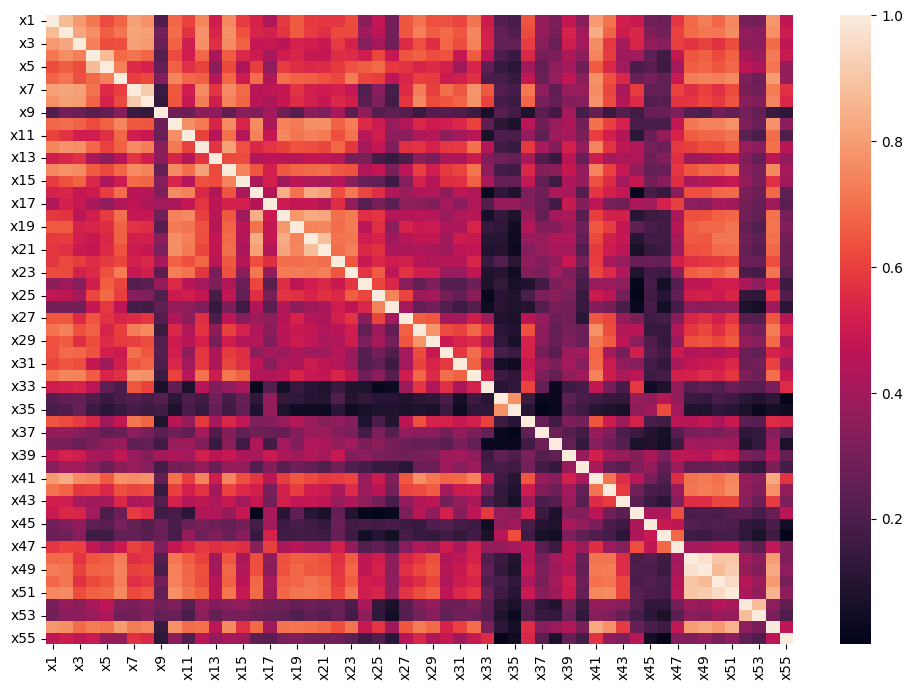

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
df_cross_corr = df1[attr_keys].corr()
ax = sns.heatmap(df_cross_corr.abs())
plt.tight_layout()
plt.show()


---

   index  abs_mean_corr           context
0     x2       0.592503    meal_mid_range
1    x41       0.587133            cinema
2    x54       0.579009  avg_month_salary
3     x1       0.571427  meal_inexpensive
4    x14       0.566969           chicken
..   ...            ...               ...
50    x9       0.260654              milk
51   x45       0.251262      summer_dress
52   x46       0.240298        nike_shoes
53   x34       0.200947           vw_golf
54   x35       0.170935    toyota_corolla


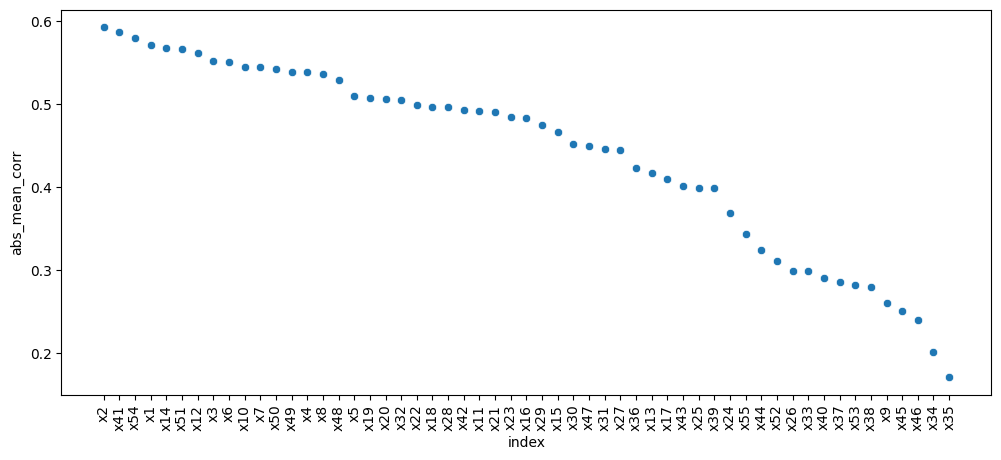

In [ ]:
# sort features by how much they correlate to other features
s_corr = df_cross_corr.abs().mean().sort_values(ascending=False)

df_list_corr = s_corr.to_frame("abs_mean_corr").reset_index()
df_list_corr["context"] = df_list_corr["index"].apply(lambda x: attribute_names[x])

# Plot
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.scatterplot(data=df_list_corr, x="index", y="abs_mean_corr", )
plt.xticks(rotation=90)

print(df_list_corr.to_string(max_rows=10))

   index     z_std                   context
0    x43  1.178760            primary_school
1    x35  0.750509            toyota_corolla
2    x34  0.684772                   vw_golf
3    x52  0.586528   per_square_meter_center
4    x53  0.483172  per_square_meter_outside
..   ...       ...                       ...
50   x32  0.034951                   taxi_1h
51   x47  0.034092            business_shoes
52    x2  0.033483            meal_mid_range
53   x29  0.032914              monthly_pass
54   x36  0.032231                basic_85m2


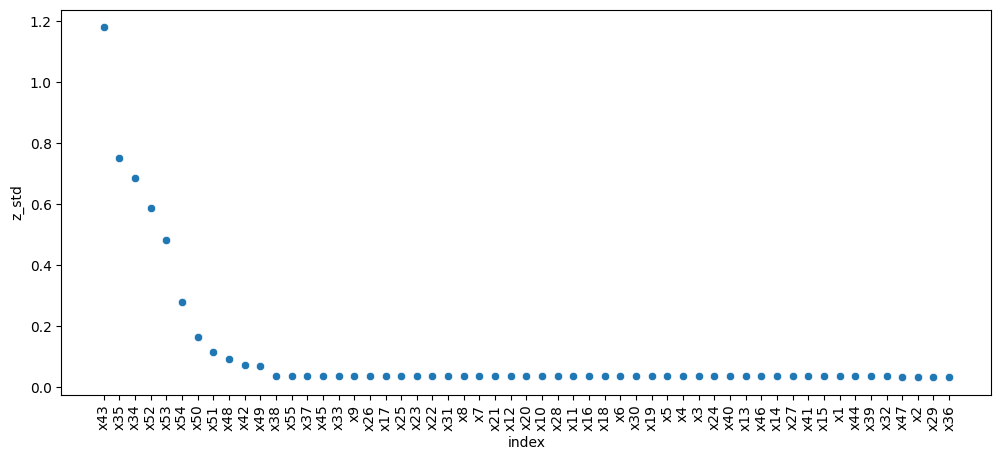

In [ ]:
# sort features by how much they deviate
s_std = df1[attr_keys].apply(ss.zscore, axis="columns").std().sort_values(ascending=False)

df_std = s_std.to_frame("z_std").reset_index()
df_std["context"] = df_std["index"].apply(lambda x: attribute_names[x])
# Plot
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.scatterplot(data=df_std, x="index", y="z_std")
plt.xticks(rotation=90)

print(df_std.to_string(max_rows=10))

## Modelling und Evaluation Regression



### Linear Regression

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Determining best features
# (= variables most strongly correlating to price of apples)
n_features = 3
best_features = (
    df_cross_corr["x16"]
    .sort_values(ascending=False)[1:1+n_features]
    .index.to_list()
)

# Print best features
string = f"The {n_features} best features are:\n"
for feature in best_features:
  string += "{} ({})\twith coefficient {:.2f}\n"\
  .format(feature, attribute_names[feature],
          df_cross_corr.loc['x16', feature])
print(string)


# Determining independent/dependent variable
X = df1[best_features]
Y = df1["x16"]

# Normalizing values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Create and fit model
model = LinearRegression()
model.fit(X_train, Y_train)

# Determine model performance
print("Model score:")
model.score(X_test, Y_test)



The 3 best features are:
x18 (oranges)	with coefficient 0.84
x20 (potato)	with coefficient 0.83
x21 (onion)	with coefficient 0.81

Model score:


0.8038942539015719

## Unüberwachtes Lernen - Clustern


## Free exploration

### Findings

- x38 hat krasse Ausreißer





In [ ]:
(df1[attribute_names.keys()].astype(float) == 0.0).sum().sort_values(ascending=False)

,0
x40,9
x2,0
x1,0
x4,0
x5,0
x6,0
x3,0
x8,0
x9,0
x10,0


In [ ]:
df1[attribute_names.keys()].describe().T

,count,mean,std,min,25%,50%,75%,max
x1,910.0,10.986571,6.278326,1.12,5.4100,10.975,15.5800,36.04
x2,910.0,49.273209,24.633477,5.56,28.9525,50.000,65.0000,150.00
x3,910.0,7.262462,2.616127,2.17,5.4750,7.210,8.9300,18.21
x4,909.0,3.745083,2.132308,0.54,1.8900,3.640,5.1900,12.36
x5,909.0,4.225941,2.052688,0.36,2.6000,4.090,5.5800,17.50
x6,910.0,2.859813,1.213821,0.30,1.7325,2.915,3.6675,5.94
x7,909.0,1.638174,0.887364,0.18,0.8900,1.650,2.2800,4.98
x8,910.0,1.197703,0.759836,0.11,0.5200,1.170,1.7000,4.37
x9,910.0,1.216791,0.520395,0.40,0.9100,1.110,1.3700,6.81
x10,910.0,1.656802,1.009196,0.11,0.8800,1.450,2.2300,6.85


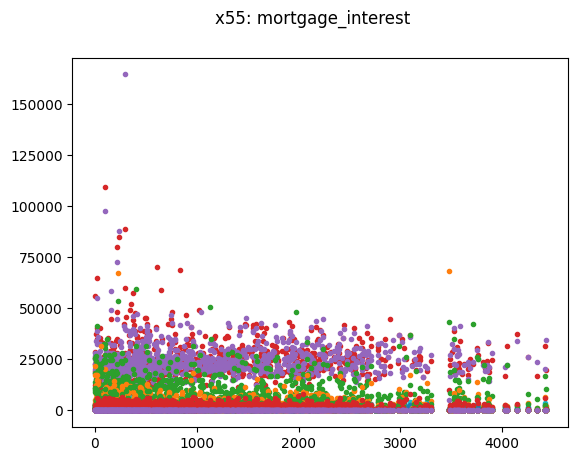

In [ ]:
for col in attribute_names.keys():
  #df1[col].hist()
  df1[col].plot(style=".")
  plt.suptitle(f"{col}: {attribute_names[col]}")
  #plt.show()

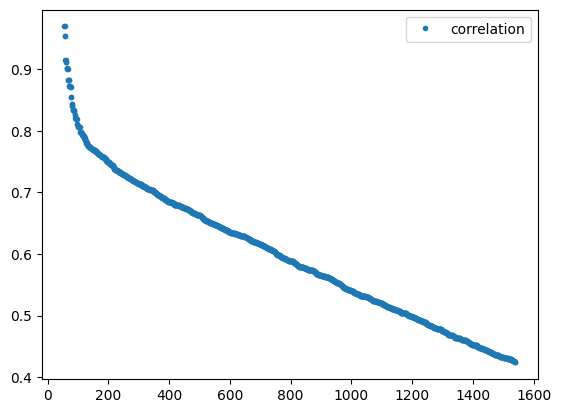

1485


np.int64(263)

In [ ]:

# compute correlations
pairs = []
num_cols = [col for col in df1.columns if ("x" in col)]
for col1 in num_cols:
    for col2 in num_cols:
        pairs.append((col1, col2, df1[col1].corr(df1[col2])))

# store as dataframe
df_corr = (
    pd.DataFrame(pairs, columns=["column_1", "column_2", "correlation"])
    .sort_values(by="correlation", ascending=False)
    .reset_index(drop=True)
)
df_corr = df_corr[df_corr["column_1"]!=df_corr["column_2"]]
df_corr = df_corr.head(int(len(df_corr)/2))
df_corr.plot(style=".")
plt.show()
print(len(df_corr))

# pairplot of attributes that have strong correlations
strong_correlating_cols = (
    df_corr
    .head(15)
    [["column_1", "column_2"]]
    .unstack()
    .sort_values()
    .unique()
    .tolist()
)
# sns.pairplot(
#     df1[strong_correlating_cols].rename(columns=attribute_names),
#     diag_kind="kde",
# )

# Correlations with apple price attribute
(
    df_corr
    [df_corr["column_1"]=="x16"]
    .sort_values(by="correlation", ascending=False)
    .reset_index(drop=True)
)

# Evaluating Number of none/nan-values
(
    (df1[num_cols].isnull() | df1[num_cols].isna())
    .sum().sum()
)

# for col in num_cols:
#     df1[col].plot.box()
#     plt.show()
